In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=(10,6)

import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from pandas.plotting import autocorrelation_plot,lag_plot

import warnings
warnings.filterwarnings('ignore')

In [23]:
ts=pd.read_csv(r"C:\Users\admin\Desktop\Extra Projects\Time series-champagne sales\perrin-freres-monthly-champagne-.csv")

In [16]:
ts.shape
ts.head()
ts.columns=['Month','Sales']
ts=ts.drop(106,axis=0)
ts.head(2)

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0


In [5]:
from datetime import datetime as dt

In [17]:
ts['Month']=pd.to_datetime(ts['Month'])
indexed_ts=ts.set_index(['Month'])

In [27]:
indexed_ts=indexed_ts.dropna()
indexed_ts.head(3)

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0


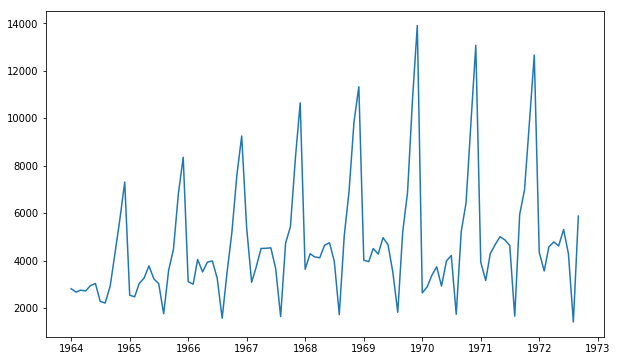

In [24]:
plt.plot(indexed_ts)

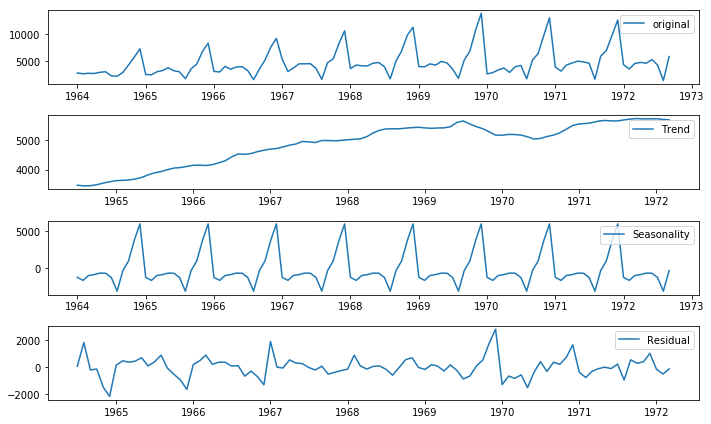

In [32]:
# DEcomposing to check trend, seasonality and other noise
decomposed=seasonal_decompose(indexed_ts['Sales'])

plt.subplot(411)
plt.plot(indexed_ts, label="original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposed.trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposed.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposed.resid,label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [47]:
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    orig=plt.plot(timeseries,color='blue',label='Original')
    rolm=plt.plot(rolmean,color='red',label='Rolmean')
    rols=plt.plot(rolstd,color='green',label='Rolstd')
    plt.legend(loc='best')
    plt.show()
    
    df_test=adfuller(timeseries)
    df_output=pd.Series(df_test[0:4],index=['Test Statistic','p_value','Lags','No of Obs'])
    for key, value in df_test[4].items():
        df_output['Critical Value {}'.format(key)] =value
    print(df_output)
    
    if (df_test[1] <0.05):
        print("Data is stationary, Reject H0")
    else:
        print("Data is Non stationary, Accept H0")

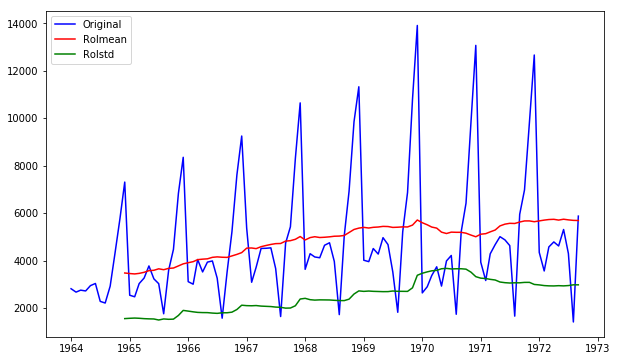

Test Statistic        -1.833593
p_value                0.363916
Lags                  11.000000
No of Obs             93.000000
Critical Value 1%     -3.502705
Critical Value 5%     -2.893158
Critical Value 10%    -2.583637
dtype: float64
Data is Non stationary, Accept H0


In [48]:
test_stationarity(indexed_ts['Sales'])

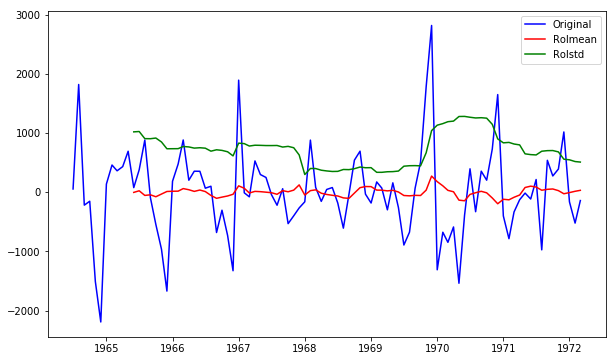

Test Statistic        -4.323381
p_value                0.000405
Lags                  11.000000
No of Obs             81.000000
Critical Value 1%     -3.513790
Critical Value 5%     -2.897943
Critical Value 10%    -2.586191
dtype: float64
Data is stationary, Reject H0


In [51]:
indexed_ts_decomposed=decomposed.resid
indexed_ts_decomposed.dropna(inplace=True)
test_stationarity(indexed_ts_decomposed)

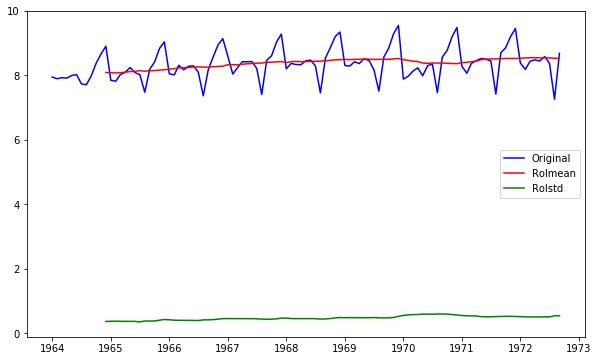

Test Statistic        -2.255119
p_value                0.186852
Lags                  13.000000
No of Obs             91.000000
Critical Value 1%     -3.504343
Critical Value 5%     -2.893866
Critical Value 10%    -2.584015
dtype: float64
Data is Non stationary, Accept H0


In [54]:
# Log transformation
indexed_ts_log=np.log(indexed_ts)
indexed_ts_log.dropna(inplace=True)
test_stationarity(indexed_ts_log['Sales'])

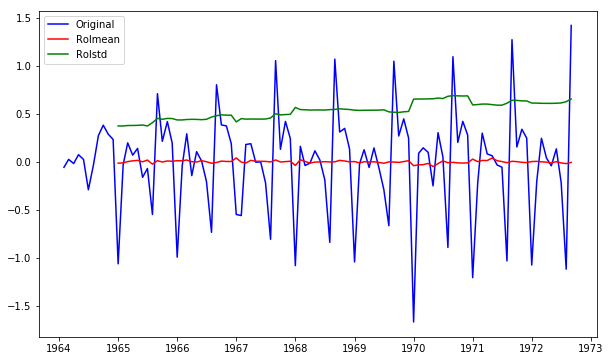

Test Statistic        -4.460914
p_value                0.000231
Lags                  12.000000
No of Obs             91.000000
Critical Value 1%     -3.504343
Critical Value 5%     -2.893866
Critical Value 10%    -2.584015
dtype: float64
Data is stationary, Reject H0


In [69]:
# Differencing of first order
indexed_ts_log_diff=indexed_ts_log.diff()
indexed_ts_log_diff.head(2)
indexed_ts_log_diff.dropna(inplace=True)
test_stationarity(indexed_ts_log_diff['Sales'])

In [74]:
indexed_ts_log_diff1=indexed_ts_log-indexed_ts_log.shift()
indexed_ts_log_diff1.dropna(inplace=True)
indexed_ts_log_diff1.head(5)

,Sales
Month,
1964-02-01,-0.052135
1964-03-01,0.030590
1964-04-01,-0.012418
1964-05-01,0.079449
1964-06-01,0.030093


In [72]:
indexed_ts_log_diff.head(5)

,Sales
Month,
1964-02-01,-0.052135
1964-03-01,0.030590
1964-04-01,-0.012418
1964-05-01,0.079449
1964-06-01,0.030093


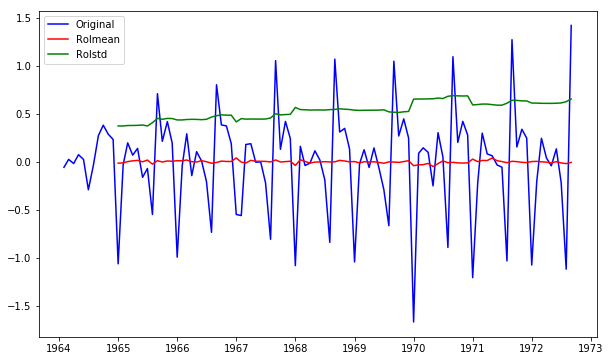

Test Statistic        -4.460914
p_value                0.000231
Lags                  12.000000
No of Obs             91.000000
Critical Value 1%     -3.504343
Critical Value 5%     -2.893866
Critical Value 10%    -2.584015
dtype: float64
Data is stationary, Reject H0


In [75]:
test_stationarity(indexed_ts_log_diff1['Sales'])

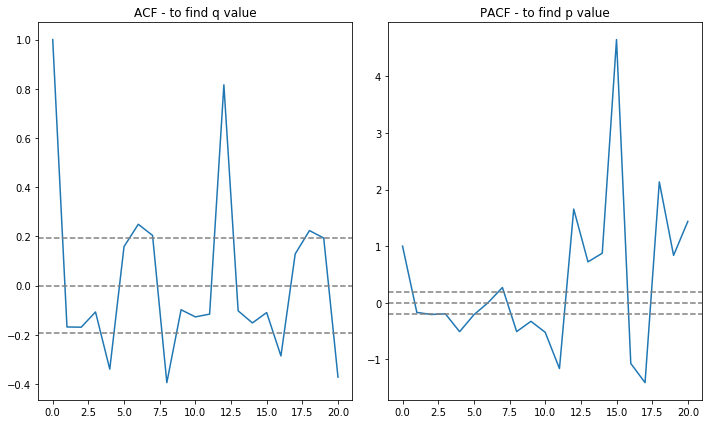

In [81]:
# Finding p and q values
acf_value=acf(indexed_ts_log_diff,nlags=20)
pacf_value=pacf(indexed_ts_log_diff,nlags=20)

plt.subplot(121)
plt.plot(acf_value)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexed_ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexed_ts_log_diff)),linestyle='--',color='gray')
plt.title('ACF - to find q value')

plt.subplot(122)
plt.plot(pacf_value)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexed_ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexed_ts_log_diff)),linestyle='--',color='gray')
plt.title('PACF - to find p value')
plt.tight_layout()
plt.show()

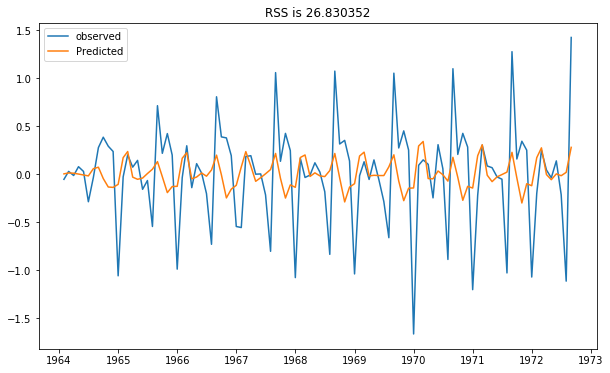

In [95]:
# mODEL BUILDING
#AR model
model=ARIMA(indexed_ts_log,order=(2,1,0))
results_AR=model.fit()
plt.plot(indexed_ts_log_diff,label='observed')
plt.plot(results_AR.fittedvalues,label='Predicted')
plt.title("RSS is {0:04f}".format(sum((results_AR.fittedvalues - indexed_ts_log_diff['Sales'])**2)))
plt.legend(loc='best')
plt.show()

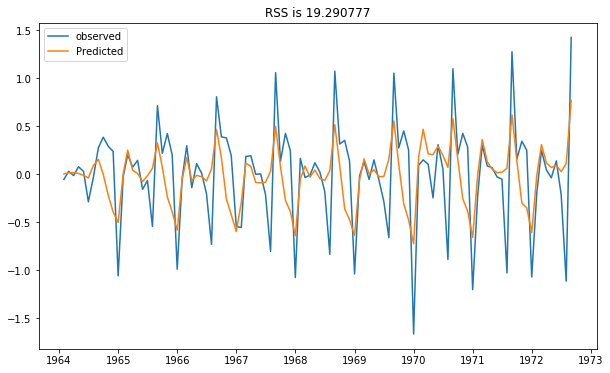

In [97]:
#MA model
model=ARIMA(indexed_ts_log,order=(0,1,2))
results_AR=model.fit()
plt.plot(indexed_ts_log_diff,label='observed')
plt.plot(results_AR.fittedvalues,label='Predicted')
plt.title("RSS is {0:04f}".format(sum((results_AR.fittedvalues - indexed_ts_log_diff['Sales'])**2)))
plt.legend(loc='best')
plt.show()

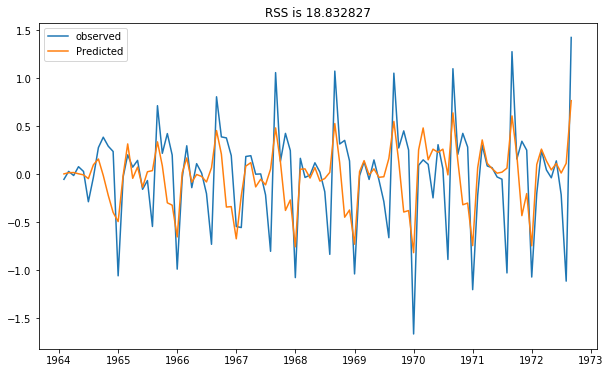

R2 score  0.34854213886436836
Root mean squared error  0.4255406838315856


In [109]:
#ARIMA model
model=ARIMA(indexed_ts_log,order=(2,1,2))
results_AR=model.fit(disp=-1)
plt.plot(indexed_ts_log_diff,label='observed')
plt.plot(results_AR.fittedvalues,label='Predicted')
plt.title("RSS is {0:04f}".format(sum((results_AR.fittedvalues - indexed_ts_log_diff['Sales'])**2)))
plt.legend(loc='best')
plt.show()
from sklearn.metrics import r2_score,mean_squared_error
import math
print("R2 score ",r2_score(indexed_ts_log_diff['Sales'],results_AR.fittedvalues) )
print("Root mean squared error " ,np.sqrt(mean_squared_error(indexed_ts_log_diff['Sales'],results_AR.fittedvalues)))

In [116]:
pred_ARIMA_diff=pd.Series(results_AR.fittedvalues,copy=True)
pred_ARIMA_diff.head()

Month
1964-02-01    0.004454
1964-03-01    0.016673
1964-04-01    0.018607
1964-05-01    0.005758
1964-06-01   -0.005710
dtype: float64

In [117]:
pred_ARIMA_diff_cumsum=pred_ARIMA_diff.cumsum()
pred_ARIMA_diff_cumsum.head()

Month
1964-02-01    0.004454
1964-03-01    0.021127
1964-04-01    0.039734
1964-05-01    0.045492
1964-06-01    0.039782
dtype: float64

In [121]:
pred_ARIMA_log=pd.Series(indexed_ts_log['Sales'].ix[0],index=indexed_ts_log.index)
pred_ARIMA_log=pred_ARIMA_log.add(pred_ARIMA_diff_cumsum,fill_value=0)
pred_ARIMA_log.head()

Month
1964-01-01    7.942718
1964-02-01    7.947172
1964-03-01    7.963845
1964-04-01    7.982451
1964-05-01    7.988209
dtype: float64

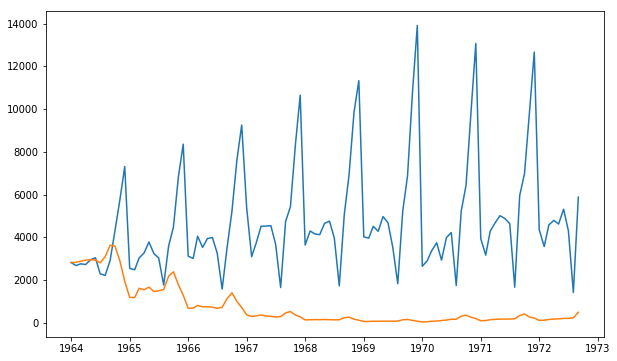

In [122]:
pred_ARIMA=np.exp(pred_ARIMA_log)
plt.plot(indexed_ts)
plt.plot(pred_ARIMA)

In [123]:
indexed_ts_log.shape

(105, 1)

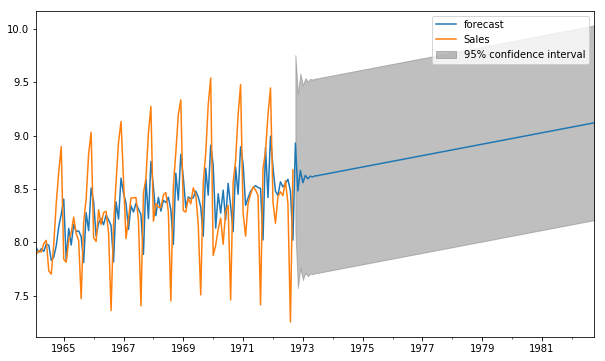

In [125]:
#want to predict for next 10 years (105+120=225)
ax=results_AR.plot_predict(1,225)

In [126]:
results_AR.forecast(steps=5)

(array([8.93053199, 8.4818399 , 8.67364416, 8.55901777, 8.62721911]),
 array([0.42072698, 0.46394754, 0.46430777, 0.46524841, 0.46541577]),
 array([[8.10592225, 9.75514173],
        [7.57251943, 9.39116037],
        [7.76361766, 9.58367066],
        [7.64714765, 9.47088789],
        [7.71502095, 9.53941726]]))

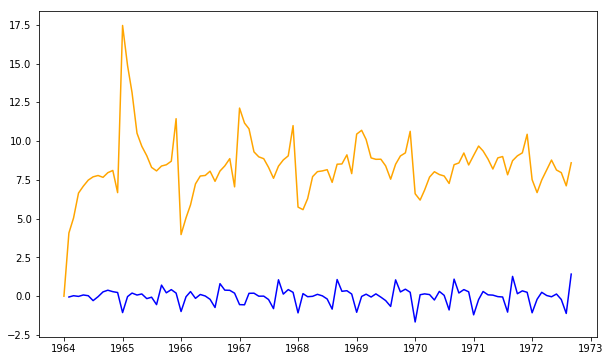

In [145]:
## SARIMAX model
from statsmodels.tsa.statespace import sarimax

sarmod=sarimax.SARIMAX(indexed_ts_log,order=(2,1,2),seasonal_order=(2,1,2,12),enforce_invertibility=False)
results_SAR=sarmod.fit(disp=-1)

plt.plot(indexed_ts_log_diff,color='blue')
plt.plot(results_SAR.fittedvalues, color='orange')
#print("R2 score ",r2_score(indexed_ts_log_diff['Sales'],results_SAR.fittedvalues) )
#print("Root mean squared error " ,np.sqrt(mean_squared_error(indexed_ts_log_diff['Sales'],results_SAR.fittedvalues)))